# 분류 알고리즘에 대한 탐색

고등학생과 미국 인구조사국 학생들이 손으로 쓴 70,000개의 작은 숫자 이미지를 모은 MNIST 데이터셋 사용

각 이미지에는 어떤 숫자를 나타내는지 레이블 되어있음

In [1]:
import sys
assert sys.version_info >= (3, 5)

import sklearn
assert sklearn.__version__ >= "0.20"

import numpy as np
import os

np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

**MNIST 데이터셋 내려받기**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [5]:
X.shape 
# 70000개의 이미지가 있고 각 이미지에는 28x28=784개의 특성이 있음
# 특성은 각각 픽셀 강도(0(흰색)부터 255(검정)까지)

(70000, 784)

In [6]:
y.shape
# 70,000개의 레이블

(70000,)

한 개의 이미지를 확인해보기

- 샘플의 특성 벡터를 추출해서 28x28 배열로 크기를 바꾸고 imshow() 함수 이용

그림 저장: some_digit_plot


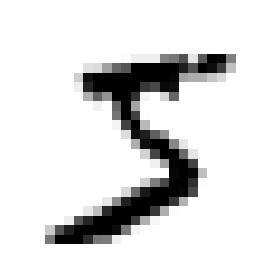

In [8]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")

save_fig("some_digit_plot")
plt.show()

숫자 **5**로 보임

실제 레이블 확인

In [9]:
y[0]

'5'

In [18]:
y = y.astype(np.uint8)

In [10]:
# 이미지 확인하는 과정을 plot_digit로 정의
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off") 

In [11]:
# 숫자 그림을 위한 추가 함수
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

그림 저장: more_digits_plot


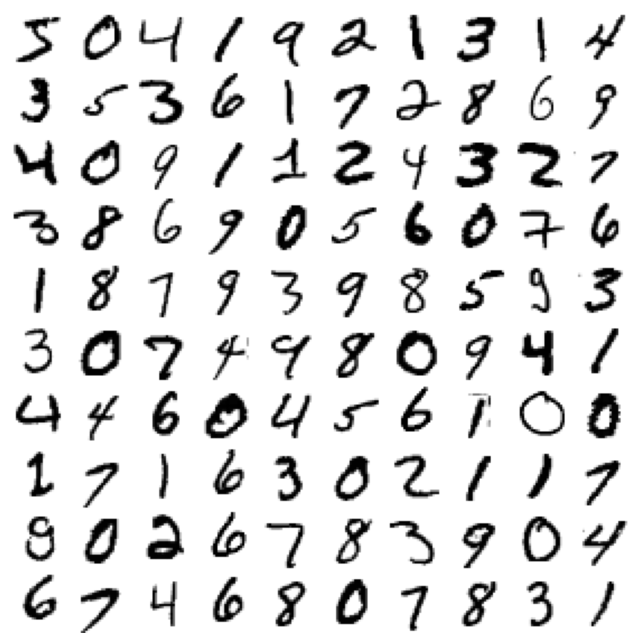

In [19]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
save_fig("more_digits_plot")
plt.show()

레이블은 문자열인데, 머신러닝 알고리즘은 숫자를 기대하므로 y를 정수로 변환

In [12]:
y = y.astype(np.uint8)

In [20]:
y[:5]

array([5, 0, 4, 1, 9], dtype=uint8)

# 테스트 세트 만들기

MNIST 데이터셋은 이미 앞쪽의 6만 개의 이미지가 훈련 세트, 뒤의 1만 개가 테스트 세트로 나누어져 있음

In [21]:
X_train, X_test, y_train, y_test, = X[:60000],X[60000:],y[:60000],y[60000:]

훈련 세트는 이미 섞여 있어서 **모든 교차 검증 폴드를 비슷하게** 만든다

어떤 학습 알고리즘은 훈련 샘플의 순서에 민감해서 많은 비슷한 샘플이 연이어 나타나면 성능이 나빠짐
- 데이터를 섞으면 이런 문제 방지할 수 있음

# 이진 분류기 훈련

문제를 단순화해서 하나의 숫자, 여기서는 5를 식별해보기 
- 즉, '5'와 '5가 아님' 두 개의 클래스를 구분할 수 있는 이진 분류기

In [15]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)
# 레이블이 5인 인덱스를 훈련 세트, 테스트 세트에서 추출

`SGDClassifier` 클래스 사용해서 확률적 경사 하강법(SGD) 분류기 사용

사이킷런의 `SGDClassifier`와 `SGDRegression`은 샘플을 섞어야 하는 대표적인 경우이다
- 기본적으로 에포크(max_iter)마다 훈련 데이터를 다시 섞는다

In [24]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(max_iter = 1000, tol = 1e-3, random_state = 42)
sgd_clf.fit(X_train,y_train_5)

SGDClassifier(random_state=42)

In [25]:
sgd_clf.predict([some_digit])

array([ True])

# 성능 측정

교차 검증

In [26]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv = 3 , scoring = 'accuracy')

array([0.95035, 0.96035, 0.9604 ])

'5'와 '5가 아님'의 비율이 차이가 많이 나기 때문에 '5가 아님'이라고만 예측해도 어느 정도 높은 성능을 낼 수 있음

따라서 위의 점수가 좋은 점수라고는 할 수 없음

In [28]:
from sklearn.model_selection import StratifiedKFold # 클래스별 비율이 유지되도록 폴드를 만들기 위해 계층적 샘플링 수행
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits = 3, random_state = 42, shuffle = True)

for train_index , test_index in skfolds.split(X_train, y_train_5) :
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred =  clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred)) 

0.9669
0.91625
0.96785


정확도가 좋다고해서 무조건 좋은 모델이 아님

In [29]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator) :
    def fit(self, X, y=None):
        pass
    def predict(self,X):
        return np.zeros((len(X), 1), dtype = bool)
# 무조건 0(5가 아님) 으로 예측
       

**cross validation score** 측정

In [30]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf,X_train,y_train_5,cv=3,scoring = 'accuracy')
# 불균형한 분류 문제에서 이런 문제 자주 발생

array([0.91125, 0.90855, 0.90915])

'5가 아님'의 비율이 훨씬 높기 때문에 '5가 아님'으로만 예측하는 경우에도 높은 정확성을 보임

정확도만으로 모델을 평가하기 어렵기 때문에 분류기의 성능을 평가하는 다른 방법 탐색

# 오차 행렬

기본적인 아이디어는 클래스 A의 샘플이 클래스 B로 분류된 횟수를 측정하는 것

ex. 분류기가 숫자 5의 이미지를 3으로 잘못 분류한 횟수를 알고 싶다면 오차 행렬의 5행 3열을 보면 된다

오차 행렬을 만들기 위해서는 실제 타깃과 비교할 수 있도록 먼저 예측값을 만들어야 함

`cross_val_predict()` 함수 사용

In [33]:
from sklearn.model_selection import cross_val_predict #cross_val_predict는 정확도를 return하는 것이 아니라 검증 세트에서 예측한 값을 return

y_train_pred = cross_val_predict(sgd_clf,X_train, y_train_5,cv=3)

`cross_val_score()` 함수처럼 `cross_val_predict()` 함수는 k-겹 교차 검증을 수행하지만 평가 점수를 반환하지 않고 각 테스트 폴드에서 얻은 예측 반환

In [34]:
from sklearn.metrics import confusion_matrix # confusion matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [35]:
y_train_perfect_predictions = y_train_5 # 완벽하게 예측한 상황을가정
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

In [36]:
from IPython.display import Image

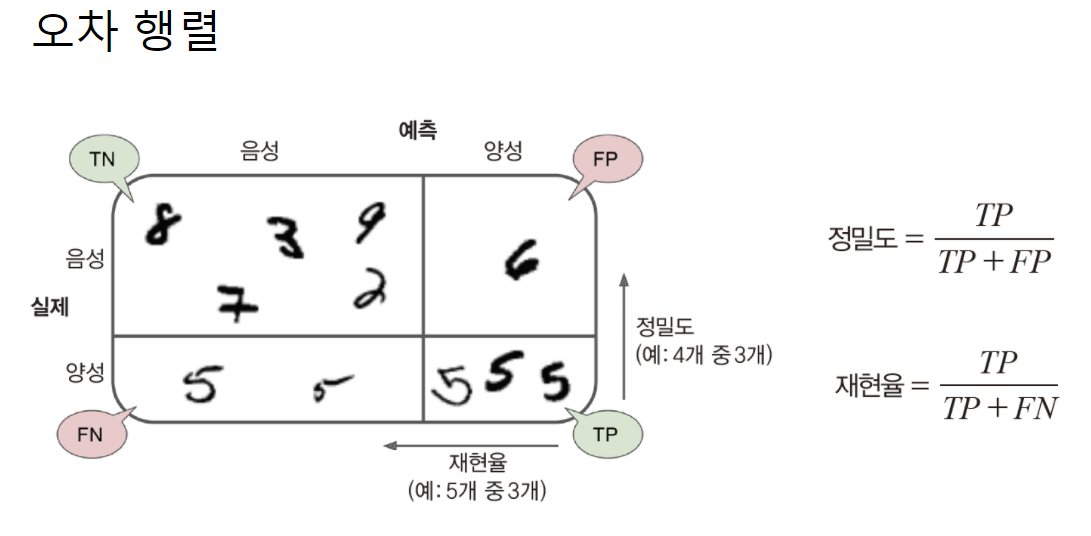

In [38]:
Image('pictures/1.png')

**정밀도** : 양성 클래스로 예측한 것 중에서 진짜 양성인 것의 비율

**재현율** : 실제 양성 클래스 중에서 양성 클래스로 분류된 것의 비율

In [39]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5,y_train_pred) # 정밀도

0.8370879772350012

In [40]:
3530 / (3530 + 687) # 정밀도

0.8370879772350012

In [41]:
recall_score(y_train_5,y_train_pred) # 재현율

0.6511713705958311

In [42]:
3530/(3530+1892) # 재현율

0.6510512725931391

두 개의 지표를 하나로 묶은 **F_1 score**

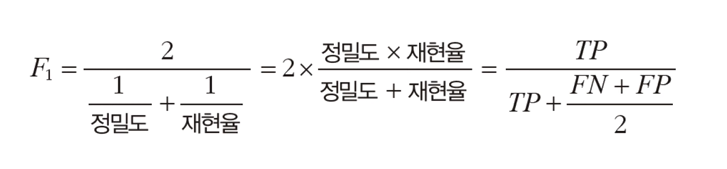

In [43]:
Image('pictures/2.png')

In [44]:
from sklearn.metrics import f1_score

f1_score(y_train_5,y_train_pred) #F_1 score

0.7325171197343846

In [45]:
3530 / (3530 + ( 687 + 1891) / 2)

0.7325171197343847

예측의 판단 기준은 **decision_function**

In [46]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [48]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
# 각 샘플의 점수를 계산한 후 이 점수가 임곗값보다 크면 양성 클래스에 할당하고 작으면 음성 클래스에 할당

In [49]:
y_some_digit_pred

array([ True])

In [50]:
threshold = 8000 # 임계값 상향조정, some_digit의 점수는 2164.22030239이므로 음성 클래스로 분류
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

적절한 임곗값 설정하기 위해서 `cross_val_predict()` 함수를 사용해서 훈련 세트의 모든 샘플의 점수를 구해야 한다

예측 결과가 아닌 결정 점수를 반환하도록 설정( `method = 'decision_function` )

In [51]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method = 'decision_function')

In [52]:
from sklearn.metrics import precision_recall_curve

precisions,recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

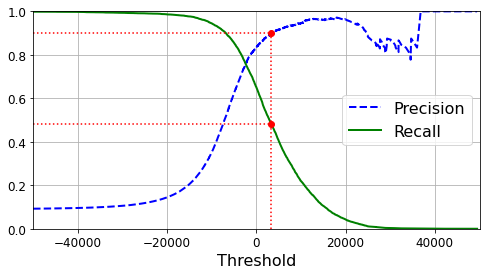

In [65]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
plt.savefig("precision_recall_vs_threshold_plot")                                              # Not shown
plt.show()

Threshold 값이 증가할수록 정밀도는 증가하고 재현율은 낮아지는 경향이 있음
- Threshold 값이 증가할수록 점수가 높은 샘플들만 양성 클래스로 분류가 되고, 양성으로 예측한 샘플이 양성일 확률이 높아짐(정밀도 증가)
- Threshold 값이 증가할수록 실제 양성 클래스지만 음성 클래스로 분류가 되는 샘플도 증가할 것임(재현율 감소)

In [68]:
(y_train_pred == (y_scores > 0 )).all()

True

### 정밀도-재현율 트레이드오프
재현율이 어느 정도 수치를 넘어가면 정밀도가 급격하게 감소하는 구간이 나온다

그 전의 값을 취하는 것이 바람직

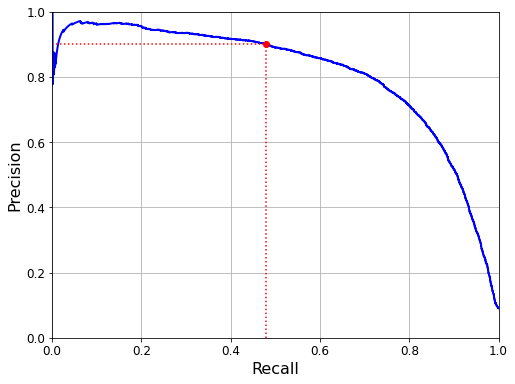

In [70]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
plt.savefig("precision_vs_recall_plot")
plt.show()

**필요한 정밀도가 90% 정도라고 가정**

precision에서 >=90 만족하는 index 찾아서 그 index에서의 임계값 찾을 수 있음

In [71]:
threshold_90_precision = thresholds[np.argmax(precisions >=0.90)]

In [72]:
threshold_90_precision

3370.0194991439557

In [73]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [74]:
precision_score(y_train_5,y_train_pred_90)

0.9000345901072293

In [75]:
recall_score(y_train_5,y_train_pred_90) # 재현율이 낮아짐

0.4799852425751706

# ROC 곡선
정밀도-재현율 곡선과 비슷하지만, ROC 곡선은 **거짓 양성 비율(FPR)에 대한 진짜 양성 비율(TPR)**의 곡선

FPR : 양성으로 잘못 분류된 음성 샘플의 비율($\dfrac{FP}{TN+FP}$)

TPR : 양성으로 제대로 분류된 양성 샘플의 비율($\dfrac{TP}{TP+FN}$, 재현율과 똑같음)

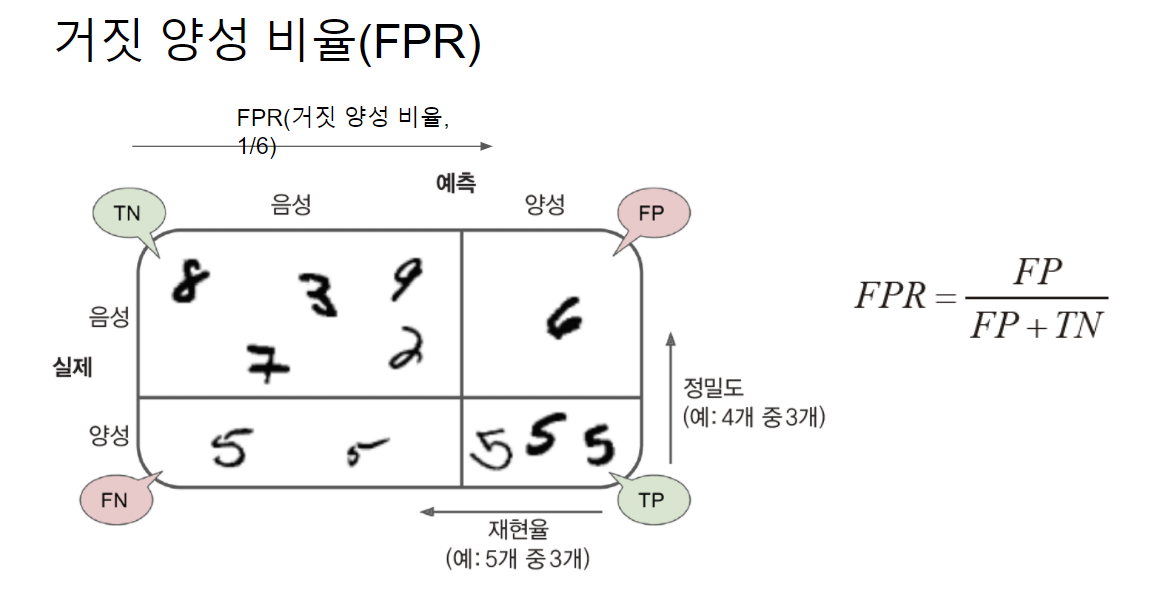

In [76]:
Image('pictures/3.png')

In [77]:
from sklearn.metrics import roc_curve

fpr,tpr,thresholds = roc_curve(y_train_5, y_scores)

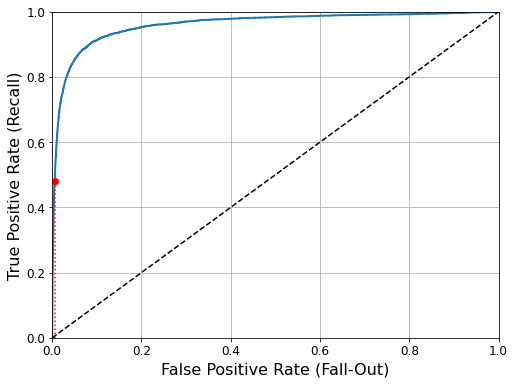

In [80]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # 대각 점선
    plt.axis([0, 1, 0, 1])                                  
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)   
    plt.grid(True)                                          

plt.figure(figsize=(8, 6))                                  
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]        
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")  
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")          
plt.savefig("roc_curve_plot")                                    
plt.show()

In [81]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)
# ROC 곡선 아래의 면적

0.9604938554008616

### PR 곡선(정밀도/재현율 곡선), ROC곡선 중 어느 것을 사용하는 것이 좋은가?

일반적으로는 양성 클래스가 드물거나 거짓 음성보다 거짓 양성이 더 중요할 때 PR 곡선을 사용하고 그렇지 않으면 ROC 곡선을 사용

예를 들어 위의 ROC 곡선을 보면 매우 좋은 분류기로 보이지만 이는 음성(5가 아님)에 비해 양성(5)가 훨씬 적기 때문

이와는 다르게 PR 곡선은 분류기의 성능 개선 여지가 얼마나 되는지(오른쪽 위의 모서리에 가까워질 수 있는지)를 보여줌

# RandomForestClassifier

In [82]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state = 42)
y_probas_forest = cross_val_predict(forest_clf,X_train,y_train_5, cv=3, method = 'predict_proba') 
# predict_proba : 예측 확률 반환

In [83]:
y_probas_forest #음성, 양성에 대한 예측 확률

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       ...,
       [0.02, 0.98],
       [0.92, 0.08],
       [0.94, 0.06]])

In [84]:
y_scores_forest = y_probas_forest[:,1] # 점수 = 양성 클래스의 확률
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

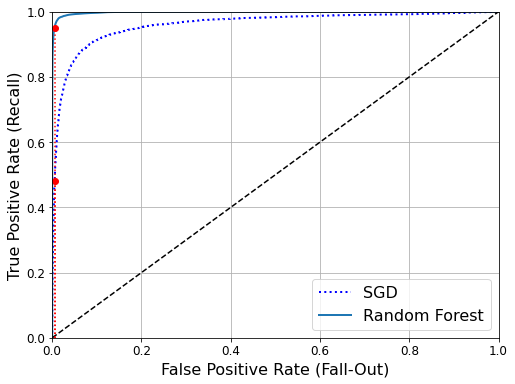

In [85]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.savefig("roc_curve_comparison_plot")
plt.show()

랜덤 포레스트같은 앙상블 모델이 좋은 결과를 내는 경우가 많음 

이 예시에서도 랜덤 포레스트가 더 우수한 성능을 보여줌

In [86]:
roc_auc_score(y_train_5,y_scores_forest)

0.9983436731328145

In [87]:
y_train_pred_forest = cross_val_predict(forest_clf,X_train,y_train_5,cv=3)
precision_score(y_train_5,y_train_pred_forest)

0.9905083315756169

In [88]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

# 다중 분류
- 클래스가 여러 개인 경우

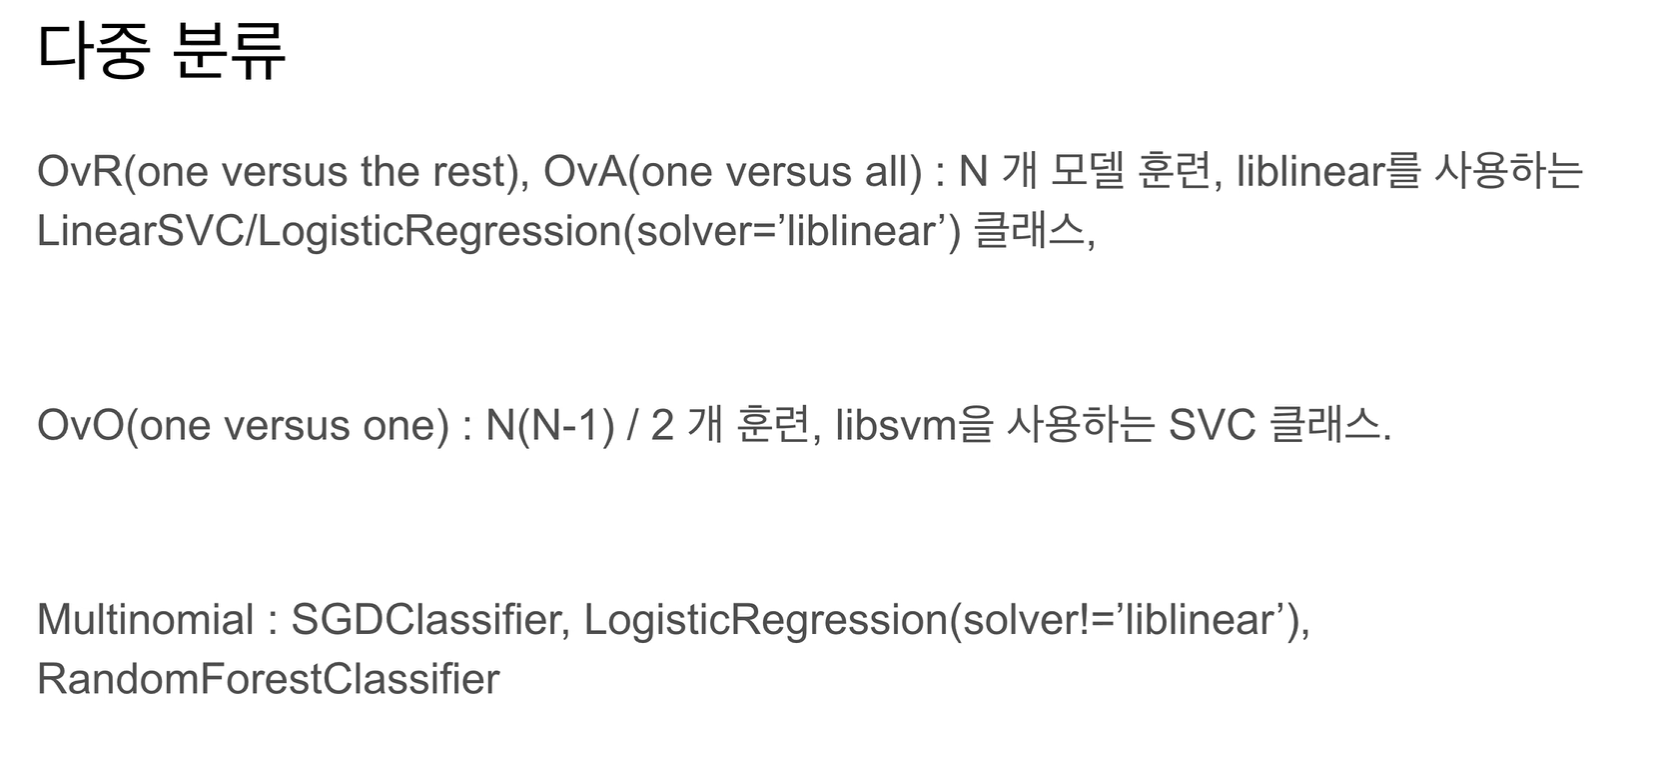

In [89]:
Image('pictures/4.png')

10개의 클래스가 존재하므로 45개의 분류기를 통해서 가장 많이 양성으로 분류된 클래스 선택

**서포트 벡터 머신**은 훈련 세트의 크기에 민감해서 큰 훈련 세트에서 몇 개의 분류기를 훈련시키는 것보다 작은 훈련 세트에서 많은 분류기를 훈련시키는 것이 빠르므로 OvO 전략을 선호(하지만 대부분의 이진 분류 알고리즘에서는 OvR 선호)

내부에서는 사이킷런이 OvO 전략을 사용해 45개의 이진 분류기를 훈련시키고 각각의 결정 점수를 얻어 점수가 가장 높은 클래스 결정

In [90]:
from sklearn.svm import SVC

svm_clf = SVC(gamma='auto', random_state = 42)
svm_clf.fit(X_train[:1000],y_train[:1000])
svm_clf.predict([some_digit])

array([5], dtype=uint8)

클래스가 10개이므로 10개의 클래스에 대한 점수 반환, 가장 점수가 높은 클래스로 분류된다

In [91]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [92]:
np.argmax(some_digit_scores)

5

In [93]:
svm_clf.classes_ # 10개의 클래스

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [94]:
svm_clf.classes_[5]

5

사이킷런에서 OvO나 OvR을 사용하도록 강제하려면 `OneVsOneClassifier`나 `OneVsRestClassifier` 사용

간단하게 이진 분류기 인스턴스를 만들어서 객체를 생성할 때 전달하면 됨

SVC 기반으로 OvR 전략을 사용하는 다중 분류기 생성

In [95]:
from sklearn.multiclass import OneVsRestClassifier 
ovr_clf = OneVsRestClassifier(SVC(gamma = 'auto', random_state = 42))
ovr_clf.fit(X_train[:1000],y_train[:1000])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [96]:
len(ovr_clf.estimators_)

10

다음의 경우 분류기는 직접 샘플을 다중 클래스로 분류할 수 있기 때문에 별도로 사이킷런의 OvO나 OvR을 적용할 필요가 없다

`decision_function()` 메서드는 클래스마다 하나의 값을 반환

In [98]:
sgd_clf.fit(X_train,y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [99]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [100]:
cross_val_score(sgd_clf, X_train, y_train, cv = 3, scoring = 'accuracy') # 각 fold 별 점수

array([0.87365, 0.85835, 0.8689 ])

모든 테스트 폴드에서 85% 이상의 정확도를 얻었음

**StandardScaler**를 이용해서 입력의 스케일을 조정하면 정확도 더 높일 수 있음

In [101]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3 , scoring = 'accuracy')

array([0.8983, 0.891 , 0.9018])

모든 테스트 폴드에서 정확도가 89% 이상으로 높아졌음

In [103]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train,y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

In [104]:
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

<ipython-input-105-8b4e051cdc79>:2: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "tight_layout" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("confusion_matrix_plot", tight_layout=False)


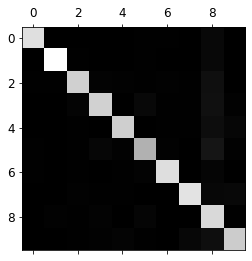

In [105]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.savefig("confusion_matrix_plot", tight_layout=False)
plt.show()

올바르게 분류된 개수를 나타낸 이미지

숫자 5가 다른 숫자보다 어둡기 때문에 다른 숫자만큼 잘 분류하지 못한다고 볼 수 있겠지만, 샘플 수 자체가 적을 수 있음

**에러의 개수**보다 **에러의 비율**을 확인

In [106]:
row_sums = conf_mx.sum(axis=1, keepdims = True)
norm_conf_mx = conf_mx / row_sums 
# 행별 비율

<ipython-input-107-560723331ef0>:3: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "tight_layout" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("confusion_matrix_errors_plot", tight_layout=False)


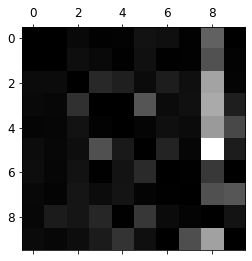

In [107]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.savefig("confusion_matrix_errors_plot", tight_layout=False)
plt.show()

많은 이미지가 8로 오분류되었음

3을 5로 오분류하고, 5를 3으로 오분류한 경우가 많이 있음

9를 8로 오분류한 경우도 꽤 많이 있음

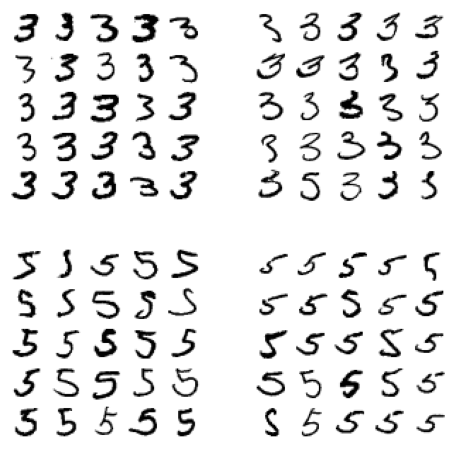

In [108]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.savefig("error_analysis_digits_plot")
plt.show()

# 다중 레이블 분류
하나의 샘플에서 여러 개의 레이블 출력

In [109]:
from sklearn.neighbors import KNeighborsClassifier

각 숫자 이미지에 두 개의 타깃 레이블이 담긴 y_multilabel 배열 생성

첫 번째는 숫자가 큰 값(7,8,9)인지를 나타내고,

두 번째는 홀수인지를 나타낸다

In [110]:
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 ==1 )
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [111]:
knn_clf.predict([some_digit])

array([[False,  True]])

다중 레이블 분류기를 평가하는 방법 중 하나로 각 레이블의 $F_1$ 점수(또는 다른 지표)를 구하고 평균 계산

In [135]:
# 실행 시간 오래 걸림
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.9786580239202405

#### 다중 출력 분류

다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화한 것

이미지에서 잡음을 제거하는 시스템 생성

잡음이 많은 숫자 이미지를 입력으로 받고 깨끗한 숫자 이미지를 MNIST 이미지처럼 픽셀의 강도를 담은 배열로 출력

분류기의 출력이 다중 레이블(픽셀당 한 레이블)이고 각 레이블은 여러 개(0 ~ 255)를 가짐

In [117]:
noise = np.random.randint(0,100,(len(X_train),784))
X_train_mod = X_train + noise
noise = np.random.randint(0,100,(len(X_test),784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

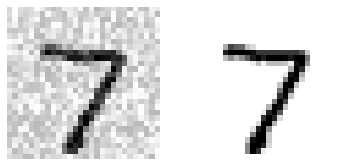

In [118]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.savefig("noisy_digit_example_plot")
plt.show()

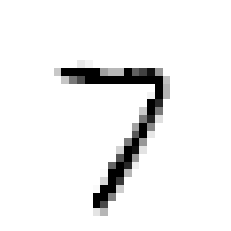

In [119]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)
plt.savefig("cleaned_digit_example_plot")

# 더미(랜덤) 분류기
다른 모델과의 성능 비교를 위한 Base model

ROC 곡선이 직선의 형태를 가짐

In [123]:
from sklearn.dummy import DummyClassifier
# 0.24 버전부터 strategy의 기본값이 'stratified'에서 'prior'로 바뀌므로 명시적으로 strategy 지정
dmy_clf = DummyClassifier(strategy = 'stratified')
y_probas_dmy = cross_val_predict(dmy_clf, X_train, y_train_5, cv = 3, method = 'predict_proba')
y_scores_dmy = y_probas_dmy[:,1]

In [122]:
y_probas_dmy

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

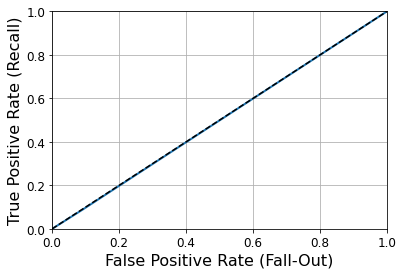

In [124]:
fprr, tprr, threshold = roc_curve(y_train_5, y_scores_dmy)
plot_roc_curve(fprr,tprr)

# KNN 분류기

In [125]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(weights = 'distance', n_neighbors = 4)
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [126]:
y_knn_pred = knn_clf.predict(X_test)

In [127]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_knn_pred)

0.9714

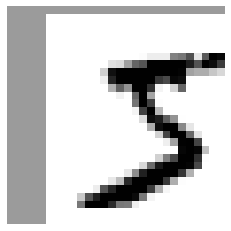

In [128]:
from scipy.ndimage.interpolation import shift
def shift_digit(digit_array, dx, dy, new=0):   # 이미지를 위아래로 조금씩 이동해서 훈련 세트를 증가시켜서 훈련
    return shift(digit_array.reshape(28, 28), [dy, dx], cval=new).reshape(784)

plot_digit(shift_digit(some_digit, 5, 1, new=100))

In [129]:
X_train_expanded = [X_train]
y_train_expanded = [y_train]
for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)): # 원본 데이터를 4방향으로 움직여서 복제(1개당 5개의 이미지로 복제)
    shifted_images = np.apply_along_axis(shift_digit, axis=1, arr=X_train, dx=dx, dy=dy)
    X_train_expanded.append(shifted_images)
    y_train_expanded.append(y_train)

X_train_expanded = np.concatenate(X_train_expanded)
y_train_expanded = np.concatenate(y_train_expanded)
X_train_expanded.shape, y_train_expanded.shape

((300000, 784), (300000,))

In [130]:
knn_clf.fit(X_train_expanded, y_train_expanded)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [131]:
y_knn_expanded_pred = knn_clf.predict(X_test)

In [132]:
accuracy_score(y_test, y_knn_expanded_pred)

0.9763

In [133]:
ambiguous_digit = X_test[2589]
knn_clf.predict_proba([ambiguous_digit])

array([[0.24579675, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.75420325]])

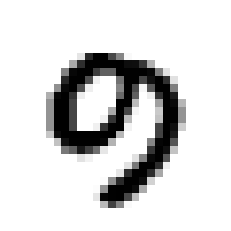

In [134]:
plot_digit(ambiguous_digit)